# Statistic Models
Neste notebook tem os seguintes modelos estatísticos:
- AR
- ARIMA
- SARIMA

## Imports

In [328]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
import statistics

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# statsmodels
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# autoarima
import pmdarima as pm

# regression
from fbprophet import Prophet

# Other
from IPython.display import Image
import warnings
import pprint
import datetime
import itertools
import os

## Prepare Principal Directory

In [329]:
def prepare_directory_work(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname(os.path.realpath("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}' 

In [330]:
prepare_directory_work(end_directory='notebooks')

'Current working directory: /home/campos/projects/tcc'

## Cell Format

In [331]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# Guarantees visualization inside the jupyter
%matplotlib inline

# Print xxxx rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.float_format', '{:.5}'.format)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# pretty print
pp = pprint.PrettyPrinter(indent=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
plt.style.use('seaborn')  # fivethirtyeight
plt.rc('figure',figsize=(16,8))
plt.rc('font',size=15)
plt.rc('legend',fontsize=15)

# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='dark', palette='deep')

plt.style.use('fivethirtyeight')

NameError: name 'plt' is not defined

## Load Data

In [333]:
%%time

df_vale3_cleansing = pd.read_csv('data/cleansing/df_vale3_cleansing.csv',
                              encoding='utf8',
                              delimiter=',',
                              verbose=True)

Tokenization took: 0.84 ms
Type conversion took: 79.86 ms
Parser memory cleanup took: 44.08 ms
CPU times: user 11.9 ms, sys: 3.86 ms, total: 15.7 ms
Wall time: 576 ms


In [334]:
print(df_vale3_cleansing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2495 non-null   object 
 1   price   2495 non-null   float64
 2   open    2495 non-null   float64
 3   high    2495 non-null   float64
 4   low     2495 non-null   float64
 5   volume  2495 non-null   float64
 6   year    2495 non-null   int64  
 7   month   2495 non-null   int64  
 8   day     2495 non-null   int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 175.6+ KB
None


In [335]:
df_vale3_cleansing.head()

,date,price,open,high,low,volume,year,month,day
0,2020-06-19,55.17,56.33,56.6,54.71,37.86,2020,6,19
1,2020-06-18,56.17,56.3,56.54,55.61,25.69,2020,6,18
2,2020-06-17,56.2,55.49,56.44,55.15,27.57,2020,6,17
3,2020-06-16,55.39,55.49,55.5,54.22,29.17,2020,6,16
4,2020-06-15,53.88,52.5,54.43,52.13,27.32,2020,6,15


In [336]:
df_vale3 = df_vale3_cleansing

## Format Date
Transforma a o tipo da coluna `Date` para `Datetime64`

In [337]:
df_vale3_cleansing['Date'] = pd.to_datetime(df_vale3_cleansing['date'],
                                            format='%Y/%m/%d',
                                            errors='raise')

In [338]:
df_vale3_cleansing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2495 non-null   object        
 1   price   2495 non-null   float64       
 2   open    2495 non-null   float64       
 3   high    2495 non-null   float64       
 4   low     2495 non-null   float64       
 5   volume  2495 non-null   float64       
 6   year    2495 non-null   int64         
 7   month   2495 non-null   int64         
 8   day     2495 non-null   int64         
 9   Date    2495 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 195.0+ KB


## Use date how index

In [339]:
df_vale3_date_index = df_vale3_cleansing
df_vale3_date_index.index.names = ['date']
df_vale3_date_index.index = df_vale3_cleansing['date']
df_vale3_date_index.index = pd.to_datetime(df_vale3_cleansing.index)

print(df_vale3_date_index.index.freq)
print(df_vale3_date_index.index)

None
DatetimeIndex(['2020-06-19', '2020-06-18', '2020-06-17', '2020-06-16',
               '2020-06-15', '2020-06-12', '2020-06-10', '2020-06-09',
               '2020-06-08', '2020-06-05',
               ...
               '2010-06-02', '2010-06-01', '2010-05-31', '2010-05-28',
               '2010-05-27', '2010-05-26', '2010-05-25', '2010-05-24',
               '2010-05-21', '2010-05-20'],
              dtype='datetime64[ns]', name='date', length=2495, freq=None)


In [340]:
df_vale3_cleansing = df_vale3_cleansing['price']

## Train and Test

In [341]:
size_train = int(len(df_vale3_cleansing)*0.8)
size_test = int(len(df_vale3_cleansing)*0.2)
print(size_train)
print(size_test)

df_train = df_vale3_cleansing.iloc[size_test:]
df_test = df_vale3_cleansing.iloc[:size_test]

1996
499


Text(0.5, 1.0, 'Train size: 1996')

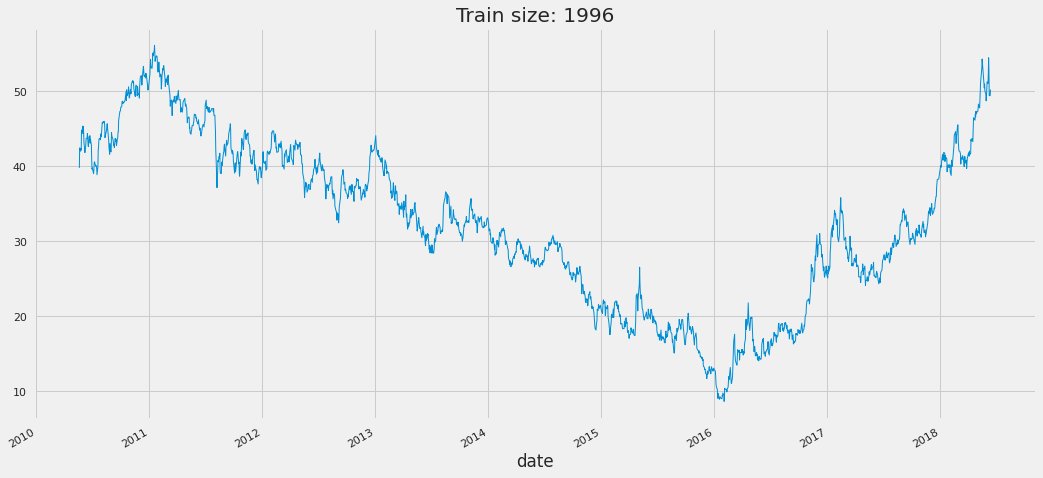

In [342]:
df_train.plot(linewidth=1)
plt.grid(True)
plt.title(f'Train size: {len(df_train)}')

Text(0.5, 1.0, 'Test size: 499')

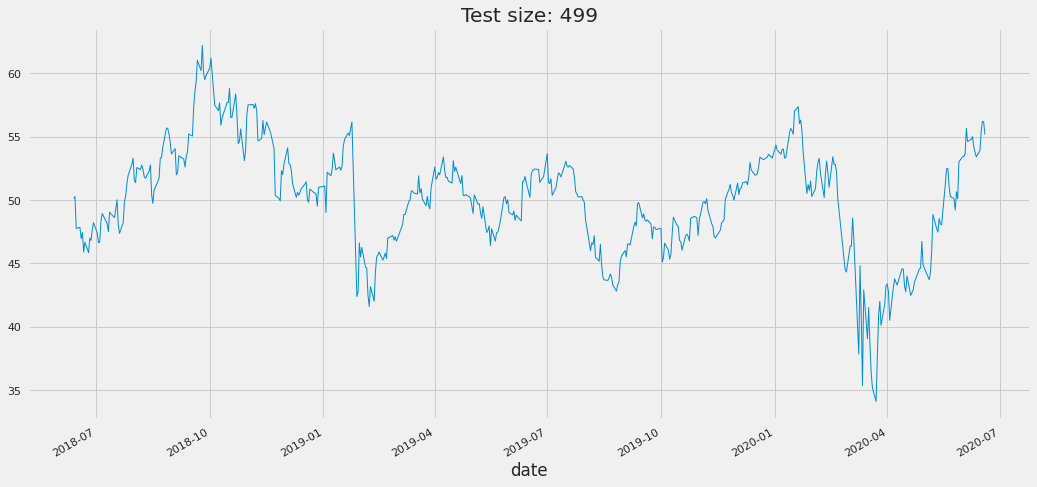

In [343]:
df_test.plot(linewidth=1)
plt.grid(True)
plt.title(f'Test size: {len(df_test)}')

### Handling index

In [344]:
df_test = df_test.iloc[::-1]

In [345]:
df_train = df_train.iloc[::-1]

In [346]:
df_train.index

DatetimeIndex(['2010-05-20', '2010-05-21', '2010-05-24', '2010-05-25',
               '2010-05-26', '2010-05-27', '2010-05-28', '2010-05-31',
               '2010-06-01', '2010-06-02',
               ...
               '2018-05-29', '2018-05-30', '2018-06-01', '2018-06-04',
               '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08',
               '2018-06-11', '2018-06-12'],
              dtype='datetime64[ns]', name='date', length=1996, freq=None)

In [347]:
df_test.index

DatetimeIndex(['2018-06-13', '2018-06-14', '2018-06-15', '2018-06-18',
               '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22',
               '2018-06-25', '2018-06-26',
               ...
               '2020-06-05', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-12', '2020-06-15', '2020-06-16', '2020-06-17',
               '2020-06-18', '2020-06-19'],
              dtype='datetime64[ns]', name='date', length=499, freq=None)

In [348]:
df_train.reset_index(drop=True, inplace=True)
df_train.index

RangeIndex(start=0, stop=1996, step=1)

In [349]:
df_test.reset_index(drop=True, inplace=True)
df_test.index

RangeIndex(start=0, stop=499, step=1)

In [350]:
df_train.index = pd.RangeIndex(start=0, stop=1996, step=1)
df_train.index

RangeIndex(start=0, stop=1996, step=1)

In [351]:
df_test.index = pd.RangeIndex(start=1996, stop=2495, step=1)
df_test.index

RangeIndex(start=1996, stop=2495, step=1)

## Metric to Evaluation

In [352]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Grid Search
- Grid Search: https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

In [353]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
print(f'All different combinations of p, q and q:\n {pdq}')

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(f'\n\nAll different combinations of seasonal p, q and q:\n {seasonal_pdq}')

All different combinations of p, q and q:
 [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]


All different combinations of seasonal p, q and q:
 [(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12)]


In [354]:
def search_best_params_arima_model(df_train):  
    best_model = 99999
    param = ()
    
    for param in pdq:
        try:
            arima_model = ARIMA(df_train, order=param)
            results = arima_model.fit()
            print(f'pdq = {param} | AIC = {results.aic}')
            
            if results.aic < best_model:
                best_model = results.aic
        except: 
            continue
    
    print(f'best ARIMA: {param} - AIC:{results.aic}')
    return [param, best_model]

In [355]:
def search_best_params_sarima_model(df_train, trend, pdq):  
    best_model = 99999
    param = ()
    param_seasonal = ()
    
    for param_seasonal in seasonal_pdq:
        try:
            sarima_model = SARIMAX(df_train,
                                   order=pdq,
                                   seasonal_order=param_seasonal,
                                   trend=trend,          
                                   enforce_stationarity=True,
                                   enforce_invertibility=False)
            results = sarima_model.fit()
            print(f'pdq = {pdq} | param_seasonal = {param_seasonal} | AIC = {results.aic}')

            if results.aic < best_model:
                best_model = results.aic
        except: 
            continue
    
    print(f'\n\nbest SARIMA: {pdq}x{param_seasonal}12 - AIC:{best_model}')
    return [param_seasonal, best_model]

## Save Results

In [356]:
dict_results = {}

## Show Results

In [359]:
def show_result_model(df_train, df_test, y_forecast, model_name):
    future_forecast = pd.DataFrame(y_forecast,
                                   index=df_test.index,
                                   columns=['Previsão'])
    mape = mean_absolute_percentage_error(df_test, y_forecast)
    dict_results[model_name] = mape
    
    # plot
    pd.concat([df_train, df_test, future_forecast], axis=1).plot()

    plt.legend()
    plt.grid(True)
    plt.xlabel("Time (Days)")
    plt.ylabel("Price (R$)")
    plt.title(f'MAPE = {mape} %')

## **Statistic Models**

## AR
Fiz 2 testes, sendo as seguintes caracteríticas:
- Teste 01
  - A ST não é estacionária
  - Há tendência, (trend='t')
  - Será previsto o valor de fechamento diário, (LAG=1)
- Teste 02
  - A ST não é estacionária
  - A ST tem sazonalidade anual
  - Há tendência, (trend='t')
  - Será previsto o valor de fechamento diário, (LAG=1)
  - Há sazonalidade, (seasonal=True) no período de 30 dias

#### Teste 01

In [360]:
ar_model_01 = AutoReg(df_train,
                   lags=120,
                   trend='t')
ar_fit_01 = ar_model_01.fit()

In [361]:
y_ar_forecast_01 = ar_fit_01.predict(start=1996, end=2494)

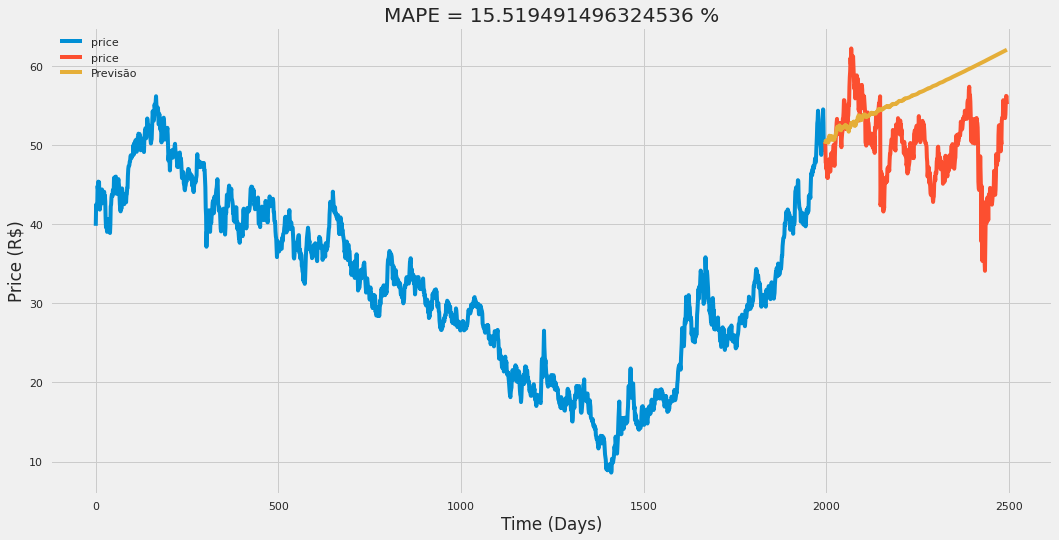

In [362]:
show_result_model(df_train=df_train,
                  df_test=df_test, 
                  y_forecast=y_ar_forecast_01,
                  model_name='ar_model_01')

#### Teste 02

In [363]:
ar_model_02 = AutoReg(df_train,
                   lags=36,
                   trend='c',
                   seasonal=True,
                   period=len(df_test))
ar_fit_02 = ar_model_02.fit()

In [364]:
# forecast
y_ar_forecast_02 = ar_fit_02.predict(start=(df_test.index[0]), end=df_test.index[-1])

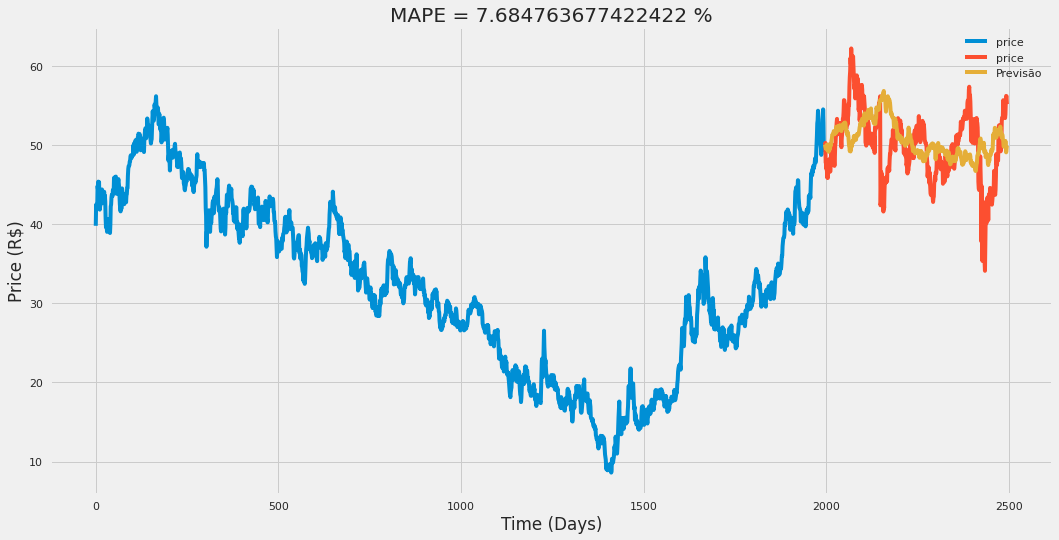

In [365]:
show_result_model(df_train=df_train,
                  df_test=df_test, 
                  y_forecast=y_ar_forecast_02,
                  model_name='ar_model_02')

#### NOTAS
- O teste 01 apresenta o melhor MAPE = 9 %
- Não é possível dizer que há sazonalidade anual pois os resultado sem sazonaliadade apresentaram o melhor MAPE

---

## MA

In [366]:
ma_model = ARMA(df_train, order=(0, 1))
ma_model

In [367]:
ma_fit = ma_model.fit()
ma_fit

In [368]:
# forecast
y_ma_forecast = ar_fit.predict(start=(df_test.index[0]), end=df_test.index[-1])

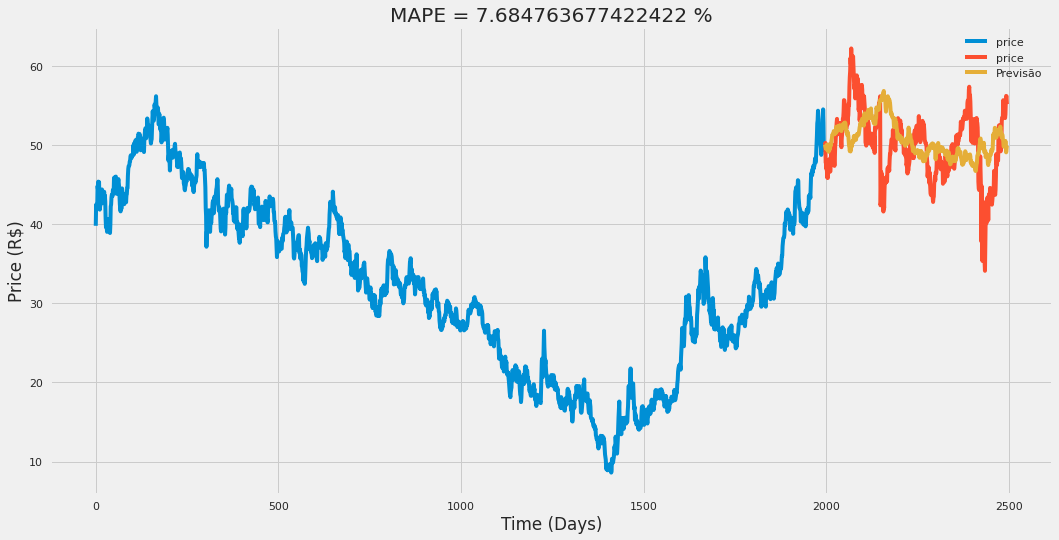

In [369]:
show_result_model(df_train=df_train,
                  df_test=df_test, 
                  y_forecast=y_ma_forecast,
                  model_name='ma_model')

---

## ARMA

In [370]:
arma_model = ARMA(df_train, order=(1, 1))
arma_model

In [371]:
arma_fit = arma_model.fit()
arma_fit

In [372]:
# forecast
y_arma_forecast = arma_fit.predict(start=(df_test.index[0]), end=df_test.index[-1])

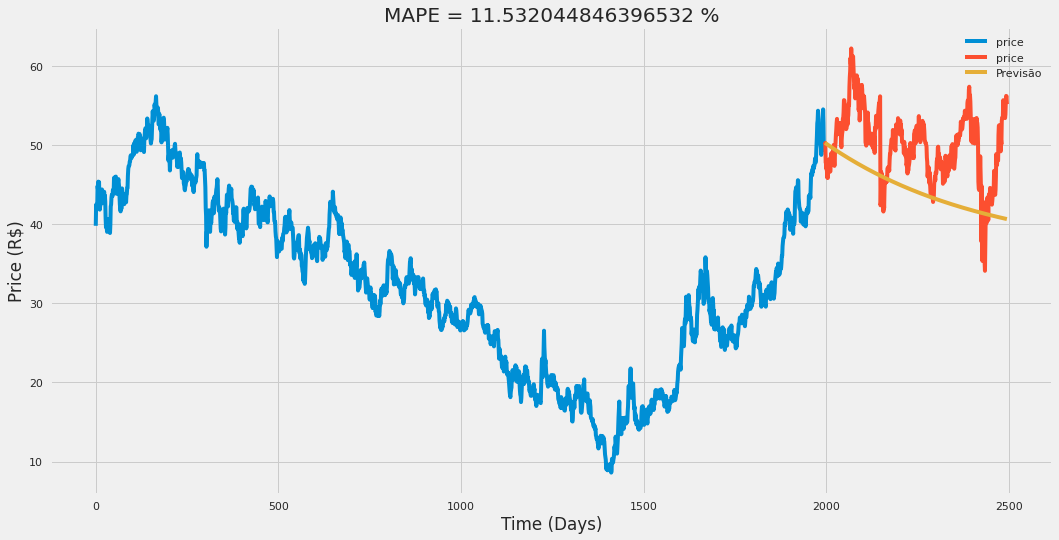

In [373]:
show_result_model(df_train=df_train,
                  df_test=df_test, 
                  y_forecast=y_arma_forecast,
                  model_name='arma_model')

---

### ARIMA

In [374]:
%%time

list_order_aic = search_best_params_arima_model(df_train)

pdq = (0, 0, 0) | AIC = 15231.624732756754
pdq = (0, 0, 1) | AIC = 12647.01250829341
pdq = (0, 1, 0) | AIC = 4383.269093830563
pdq = (0, 1, 1) | AIC = 4377.2113036530445
pdq = (0, 1, 2) | AIC = 4377.404650698405
pdq = (0, 2, 0) | AIC = 5630.887604296799
pdq = (0, 2, 1) | AIC = 4389.804362459093
pdq = (0, 2, 2) | AIC = 4383.856410058066
pdq = (1, 0, 0) | AIC = 4390.9616995748365
pdq = (1, 0, 1) | AIC = 4384.643431977538
pdq = (1, 0, 2) | AIC = 4384.980515340121
pdq = (1, 1, 0) | AIC = 4377.78654639964
pdq = (1, 1, 1) | AIC = 4378.542940408054
pdq = (1, 2, 0) | AIC = 5189.959263954155
pdq = (1, 2, 1) | AIC = 4384.43078238455
pdq = (1, 2, 2) | AIC = 4385.181681631025
pdq = (2, 0, 0) | AIC = 4385.219572169422
pdq = (2, 0, 1) | AIC = 4386.014684201961
pdq = (2, 1, 0) | AIC = 4376.4721466779965
pdq = (2, 1, 1) | AIC = 4375.06565747331
pdq = (2, 1, 2) | AIC = 4371.531309700923
pdq = (2, 2, 0) | AIC = 4994.56789920377
pdq = (2, 2, 1) | AIC = 4383.049528436848
pdq = (2, 2, 2) | AIC = 4386.69104

In [375]:
# model
order = tuple(list_order_aic[0])
arima_model = ARIMA(df_train, order=order)

print(arima_model)

In [376]:
# fit
arima_fit = arima_model.fit(y=df_train)
arima_fit

In [377]:
# forecast
y_forecast, se, conf = arima_fit.forecast(len(df_test), alpha=0.1)  # 90% conf

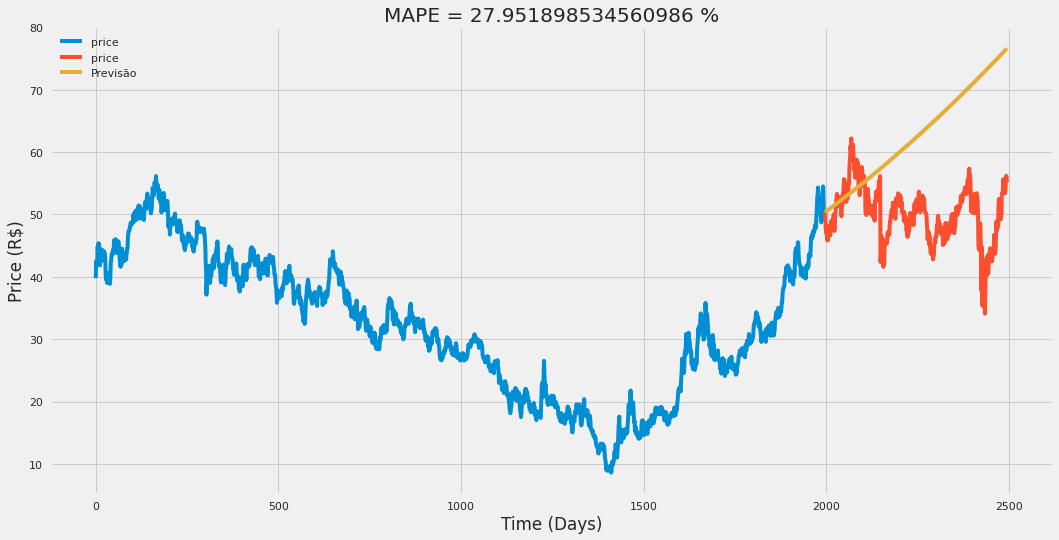

In [378]:
show_result_model(df_train=df_train,
                  df_test=df_test,
                  y_forecast=y_forecast,
                  model_name='arima_model')

## Librarie: `pmdarima`
- Tips: https://alkaline-ml.com/pmdarima/tips_and_tricks.html

In [379]:
%%time

autoarima_model = pm.auto_arima(df_train,
                                stepwise=True,
                                suppress_warnings=True,
                                error_action="ignore",
                                start_p=6,
                                start_q=6,
                                max_p=30,
                                max_q=30,
                                seasonal=False, 
                                max_order=(6, 2, 6),
                                trace=True)

Performing stepwise search to minimize aic
 ARIMA(6,1,6)(0,0,0)[0] intercept   : AIC=4374.717, Time=14.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4383.269, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4377.787, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4377.211, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4381.373, Time=0.04 sec
 ARIMA(5,1,6)(0,0,0)[0] intercept   : AIC=4374.754, Time=11.85 sec
 ARIMA(6,1,5)(0,0,0)[0] intercept   : AIC=4371.002, Time=12.57 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=4372.481, Time=12.33 sec
 ARIMA(6,1,4)(0,0,0)[0] intercept   : AIC=4376.774, Time=11.19 sec
 ARIMA(7,1,5)(0,0,0)[0] intercept   : AIC=4379.805, Time=10.13 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=10.19 sec
 ARIMA(7,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=12.50 sec
 ARIMA(7,1,6)(0,0,0)[0] intercept   : AIC=4380.785, Time=13.52 sec
 ARIMA(6,1,5)(0,0,0)[0]             : AIC=4368.797, Time=6.04 sec
 ARIMA(5,1,5)(0,0,0)[0]           

In [380]:
print(autoarima_model.order)
print(autoarima_model.aic())

(6, 1, 5)
4368.797461240003


In [381]:
# fit
autoarima_model_fit = autoarima_model.fit(y=df_train)
autoarima_model_fit

ARIMA(order=(6, 1, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [382]:
# forecast
y_forecast = autoarima_model_fit.predict(n_periods=len(df_test))
len(y_forecast)

499

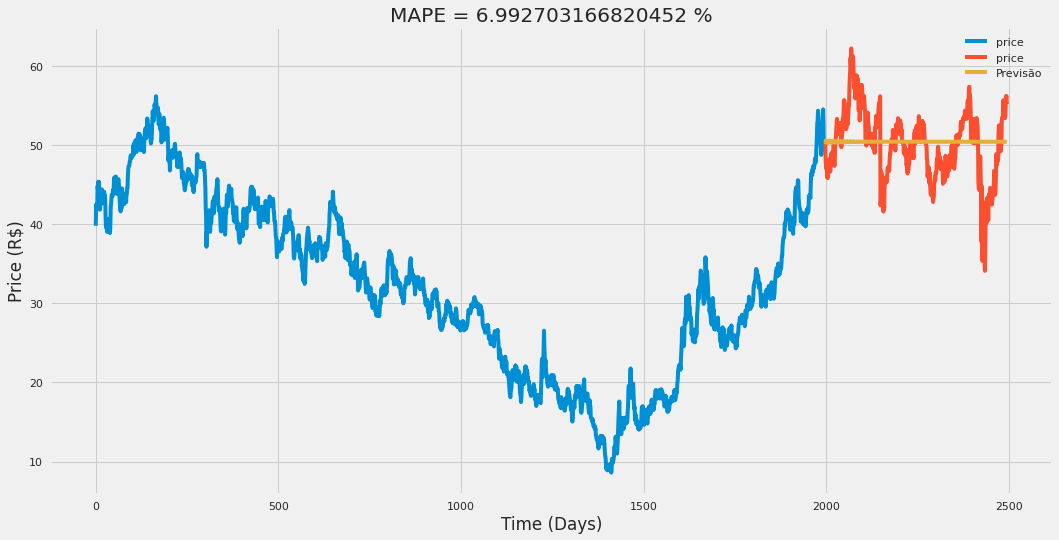

In [383]:
show_result_model(df_train=df_train,
                  df_test=df_test,
                  y_forecast=y_forecast,
                  model_name='autoarima_model')

---

## SARIMA

## Statsmodel: SARIMA

In [243]:
%%time

list_order_seasonal_aic = search_best_params_sarima_model(df_train=df_train,
                                                          trend='ct',
                                                          pdq=(6, 2, 6))
print(list_order_seasonal_aic)

pdq = (6, 2, 6) | param_seasonal = (0, 0, 0, 12) | AIC = 6419.985192315984
pdq = (6, 2, 6) | param_seasonal = (0, 0, 1, 12) | AIC = 6444.492261955902
pdq = (6, 2, 6) | param_seasonal = (0, 0, 2, 12) | AIC = 6435.161559035926
pdq = (6, 2, 6) | param_seasonal = (0, 1, 0, 12) | AIC = 5974.275031946003
pdq = (6, 2, 6) | param_seasonal = (0, 1, 1, 12) | AIC = 5093.041905410822
pdq = (6, 2, 6) | param_seasonal = (0, 1, 2, 12) | AIC = 5019.316406075693
pdq = (6, 2, 6) | param_seasonal = (0, 2, 0, 12) | AIC = 7686.057867862046
pdq = (6, 2, 6) | param_seasonal = (0, 2, 1, 12) | AIC = 7393.611269388737
pdq = (6, 2, 6) | param_seasonal = (0, 2, 2, 12) | AIC = 6720.921578831487
pdq = (6, 2, 6) | param_seasonal = (1, 0, 0, 12) | AIC = 6433.660675760107
pdq = (6, 2, 6) | param_seasonal = (1, 0, 1, 12) | AIC = 6446.580133173023
pdq = (6, 2, 6) | param_seasonal = (1, 0, 2, 12) | AIC = 6437.10760062155
pdq = (6, 2, 6) | param_seasonal = (1, 1, 0, 12) | AIC = 5463.982852539597
pdq = (6, 2, 6) | param_se

In [244]:
list_order_seasonal_aic

[(2, 2, 2, 12), 5019.316406075693]

In [245]:
sarima_model = SARIMAX(df_train,
                       order=(6, 2, 6),
                       seasonal_order=(2, 2, 2, 12),
                       trend='c',          
                       enforce_stationarity=False,
                       enforce_invertibility=False)

In [246]:
# fit
sarima_fit = sarima_model.fit()
print(sarima_fit)

In [247]:
# forecast
y_forecast_sarima = sarima_fit.predict(start=df_test.index[0], end=df_test.index[-1])
print(len(y_forecast_sarima))

499


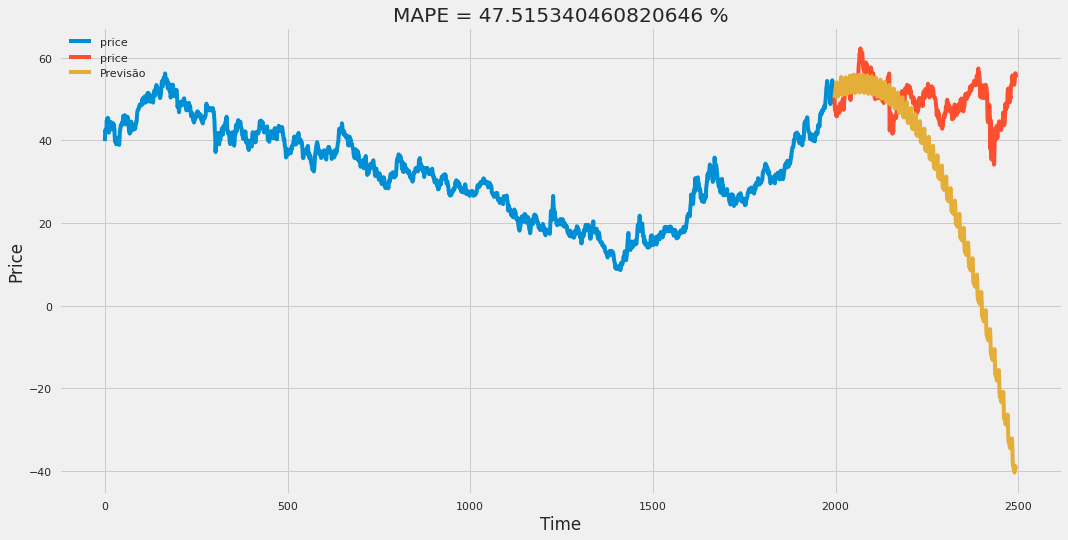

In [248]:
show_result_model(df_train=df_train,
                  df_test=df_test,
                  y_forecast=y_forecast_sarima,
                  model_name='sarima_model')

### AUTOSARIMA

In [249]:
autosarima_model = pm.auto_arima(df_train,
                                 seasonal=True,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 error_action="ignore",
                                 start_p=6,
                                 start_q=6,
                                 max_p=30,
                                 max_q=30,
                                 m=12,              # frequency of series
                                 D=1,
                                 max_order=None,
                                 trace=True)

Performing stepwise search to minimize aic
 ARIMA(6,1,6)(1,1,1)[12]             : AIC=inf, Time=103.90 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5720.413, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5173.260, Time=1.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=6.73 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5714.492, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4931.420, Time=2.84 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=17.15 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=7.56 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4939.872, Time=1.86 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4930.229, Time=4.11 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5172.290, Time=1.89 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=23.12 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=11.38 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4929.864, Time=4.37 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=5

In [250]:
# fit
autosarima_fit = autosarima_model.fit(df_train)
print(autosarima_fit)

 ARIMA(3,1,0)(2,1,0)[12]          


In [251]:
# predict
y_autosarima_predict = autosarima_fit.predict(n_periods=len(df_test))
print(type(y_autosarima_predict))
print((y_autosarima_predict[:5]))

<class 'numpy.ndarray'>
[50.38556034 50.57120662 50.91059809 51.44499976 52.50343421]


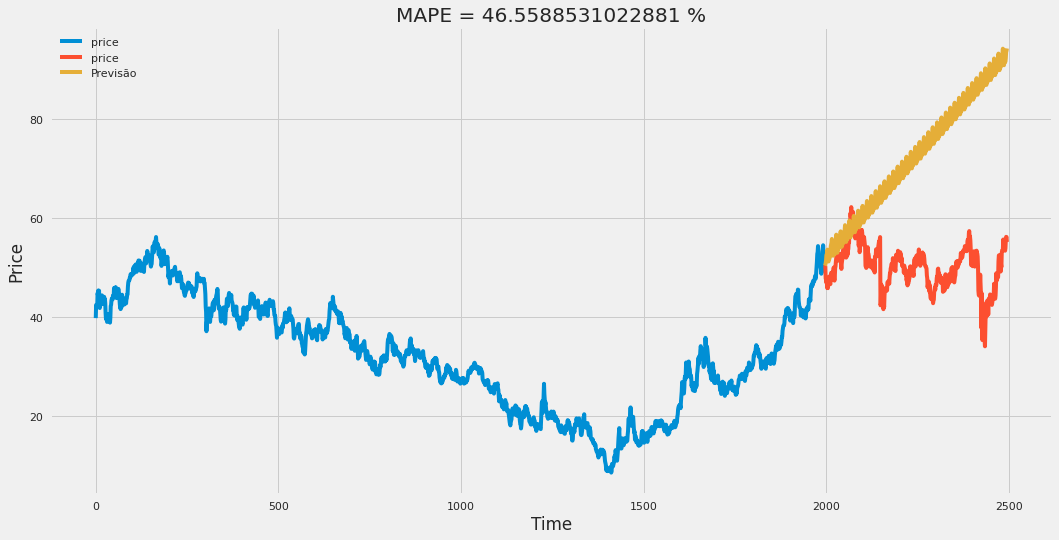

In [252]:
show_result_model(df_train=df_train,
                  df_test=df_test,
                  y_forecast=y_autosarima_predict,
                  model_name='autosarima_model')

---

### Prophet Librarie: Regression
- Paper: https://peerj.com/preprints/3190/
- 5 Conclusion: "We use a simple, modular regression model ..."

In [253]:
df_vale3.reset_index(drop=True, inplace=True)
df_vale3.head()

,date,price,open,high,low,volume,year,month,day,Date
0,2020-06-19,55.17,56.33,56.6,54.71,37.86,2020,6,19,2020-06-19
1,2020-06-18,56.17,56.3,56.54,55.61,25.69,2020,6,18,2020-06-18
2,2020-06-17,56.2,55.49,56.44,55.15,27.57,2020,6,17,2020-06-17
3,2020-06-16,55.39,55.49,55.5,54.22,29.17,2020,6,16,2020-06-16
4,2020-06-15,53.88,52.5,54.43,52.13,27.32,2020,6,15,2020-06-15


In [303]:
df_train.index

RangeIndex(start=0, stop=1996, step=1)

In [304]:
df_test.index

RangeIndex(start=1996, stop=2495, step=1)

In [300]:
# data format
df_vale3_prophet = df_vale3[["date","price"]]

In [301]:
df_vale3_prophet = df_vale3_prophet.rename(columns = {"date":"ds","price":"y"})
df_vale3_prophet_train = df_vale3_prophet[df_train.index[0]:df_train.index[-1]]

print(len(df_vale3_prophet_train))
df_vale3_prophet_train.head(5)

1995


,ds,y
0,2020-06-19,55.17
1,2020-06-18,56.17
2,2020-06-17,56.2
3,2020-06-16,55.39
4,2020-06-15,53.88


In [305]:
m = Prophet(daily_seasonality=True, growth='linear')
m.add_country_holidays(country_name='BR')

m.fit(df_vale3_prophet_train) # fit the model using all data

In [306]:
m.train_holiday_names

0                New Year's Day
1                    Tiradentes
2                  Worker's Day
3              Independence Day
4    Our Lady of the Apparition
5                All Souls' Day
6     Republic Proclamation Day
7                     Christmas
dtype: object

In [307]:
future = m.make_future_dataframe(periods=len(df_test))
prophet_prediction = m.predict(future)

In [308]:
prophet_prediction.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'All Souls' Day', 'All Souls' Day_lower', 'All Souls' Day_upper',
       'Christmas', 'Christmas_lower', 'Christmas_upper', 'Independence Day',
       'Independence Day_lower', 'Independence Day_upper', 'New Year's Day',
       'New Year's Day_lower', 'New Year's Day_upper',
       'Our Lady of the Apparition', 'Our Lady of the Apparition_lower',
       'Our Lady of the Apparition_upper', 'Republic Proclamation Day',
       'Republic Proclamation Day_lower', 'Republic Proclamation Day_upper',
       'Tiradentes', 'Tiradentes_lower', 'Tiradentes_upper', 'Worker's Day',
       'Worker's Day_lower', 'Worker's Day_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'daily', 'daily_lower',
       'daily_upper', 'holidays', 'holidays_lower', 'holidays_upper', 'weekly',
       'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms'

In [309]:
len(prophet_prediction['yhat'])

2494

In [317]:
prophet_prediction['yhat'].index[0]

0

In [318]:
df_test.index[0]

1996

In [323]:
prophet_mape = mean_absolute_percentage_error(df_test, prophet_prediction['yhat'][1995:df_test.index[-1]])
print(prophet_mape)

10.2393145279395


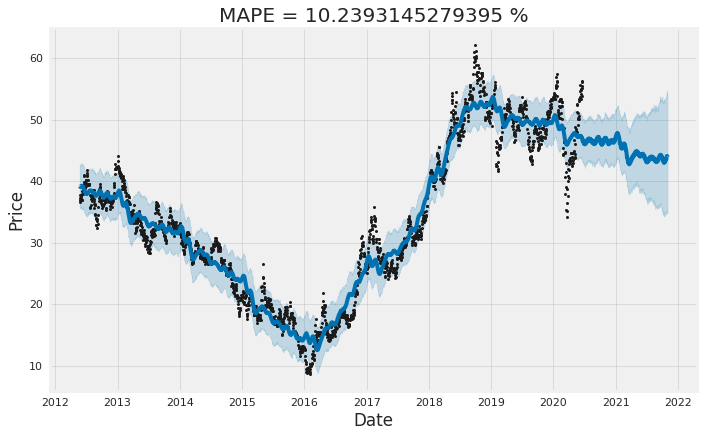

In [324]:
m.plot(prophet_prediction)
plt.title(f'MAPE = {prophet_mape} %')
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

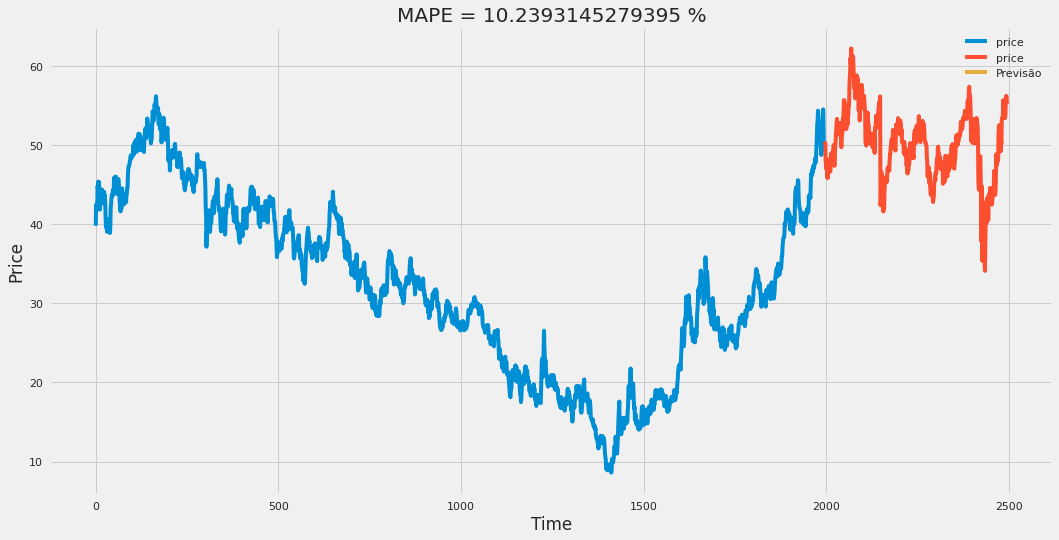

In [326]:
show_result_model(df_train=df_train,
                  df_test=df_test,
                  y_forecast=prophet_prediction[1995:df_test.index[-1]]['yhat'],
                  model_name='prophet_model')

## Results
- O melhor resultado foi de o primeiro modelo **autoregressivo** com MAPE(erro absoluto percentual médio) de 8%
- A ST que ficou com um gráfico mais parecido com o original foi o segundo modelo **autoregressivo**

In [327]:
dict_results

{'ar_model_01': 15.519491496324536,
 'ar_model_02': 7.684763677422422,
 'ma_model': 7.684763677422422,
 'arma_model': 11.532044846396532,
 'arima_model': 27.951898534560986,
 'autoarima_model': 6.992703166820452,
 'sarima_model': 47.515340460820646,
 'autosarima_model': 46.5588531022881,
 'prophet_model': 10.2393145279395}

---